In [1]:
import torch
import torch.nn as nn

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [3]:
# fix random seed for reproducibility
np.random.seed(7)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
file_path = '/content/drive/MyDrive/Solar energy prediction - Project/Datasets/Out/full.csv'

In [6]:
df = pd.read_csv(file_path, parse_dates= True, index_col= 0)
df.head()

,Solaire (MW),air_temp,precip_depth_per_hour,station_pressure_rate,Vitesse du vent à 100m (m/s),Rayonnement solaire global (W/m2)
2017-01-01 01:00:00,0,-37.0,0.0,10180.0,4.53,0.00
2017-01-01 04:00:00,0,-40.0,0.0,10162.0,5.30,0.00
2017-01-01 07:00:00,0,-41.0,0.0,10144.0,4.92,0.00
2017-01-01 10:00:00,15,-30.0,0.0,10137.0,4.71,7.09
2017-01-01 13:00:00,22,-10.0,0.0,10115.0,4.30,84.24


In [7]:
df.shape

(11688, 6)

In [8]:
dg = df.copy(deep = True)

In [9]:
df['year'] = df.index.year
df['month'] = df.index.month
df['hour'] = df.index.hour

In [10]:
df.head()

,Solaire (MW),air_temp,precip_depth_per_hour,station_pressure_rate,Vitesse du vent à 100m (m/s),Rayonnement solaire global (W/m2),year,month,hour
2017-01-01 01:00:00,0,-37.0,0.0,10180.0,4.53,0.00,2017,1,1
2017-01-01 04:00:00,0,-40.0,0.0,10162.0,5.30,0.00,2017,1,4
2017-01-01 07:00:00,0,-41.0,0.0,10144.0,4.92,0.00,2017,1,7
2017-01-01 10:00:00,15,-30.0,0.0,10137.0,4.71,7.09,2017,1,10
2017-01-01 13:00:00,22,-10.0,0.0,10115.0,4.30,84.24,2017,1,13


In [11]:
cols_to_transform = ['air_temp', 'precip_depth_per_hour', 'station_pressure_rate', 'Vitesse du vent à 100m (m/s)', 'Rayonnement solaire global (W/m2)']

In [12]:
df.index.name = 'date'

In [13]:
#df.loc['2020-02-29 01:00:00':'2020-02-29 22:00:00', :]

In [14]:
#df.drop(df.loc['2020-02-29 01:00:00':'2020-02-29 22:00:00', :].index, axis = 0, inplace = True)
df.shape

(11688, 9)

## **LSTM Data Preparation**

We will frame the supervised learning problem as predicting the solar energy at the current hour (t) given the solar measurement and weather conditions at the prior time step.

After, all features are normalized, then the dataset is transformed into a supervised learning problem. The weather variables for the hour to be predicted (t) are then removed.

In [15]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [16]:
values = dg.values

In [17]:
# ensure all data is float
values = values.astype('float32')

In [18]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [19]:
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

In [20]:
# drop columns we don't want to predict
reframed.drop(reframed.columns[[7,8,9,10,11]], axis = 1, inplace = True)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var1(t)
1,0.000000,0.067762,0.0,0.742188,0.205197,0.000000,0.000000
2,0.000000,0.061602,0.0,0.718750,0.274194,0.000000,0.000000
3,0.000000,0.059548,0.0,0.695312,0.240143,0.000000,0.025381
4,0.025381,0.082136,0.0,0.686197,0.221326,0.008387,0.037225
5,0.037225,0.123203,0.0,0.657552,0.184588,0.099649,0.001692


We can see the 6 input variables (input series) and the 1 output variable (solar energy production at the current 3-hour slot).

In [21]:
reframed.shape

(11687, 7)

## **Define and Fit Model**

First, we must split the prepared dataset into train and test sets.

To speed up the training of the model, we will only fit the model on the first year of data, then evaluate it on the remaining 3 years of data.

In [22]:
# split into train and test sets
values = reframed.values
split = 10711                    # to the date "2020-09-01"
train = values[:split, :]
test = values[split:, :]

In [23]:
print(train.shape, test.shape)

(10711, 7) (976, 7)


In [24]:
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(10711, 1, 6) (10711,) (976, 1, 6) (976,)


We will define the LSTM with 100 neurons in the first hidden layer and 1 neuron in the output layer for predicting solar energy production. The input shape will be 1 time step with 6 features.

We will use the Mean Absolute Error (MAE) loss function and the efficient Adam version of stochastic gradient descent.

The model will be fit for 100 training epochs with a batch size of 96 (8 3-hour slots per day * 12 months).

Finally, we keep track of both the training and test loss during training by setting the validation_data argument in the fit() function. At the end of the run both the training and test loss are plotted.

In [25]:
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam', metrics = ['accuracy'])

In [26]:
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=96, validation_data=(test_X, test_y), verbose=0, shuffle=False)

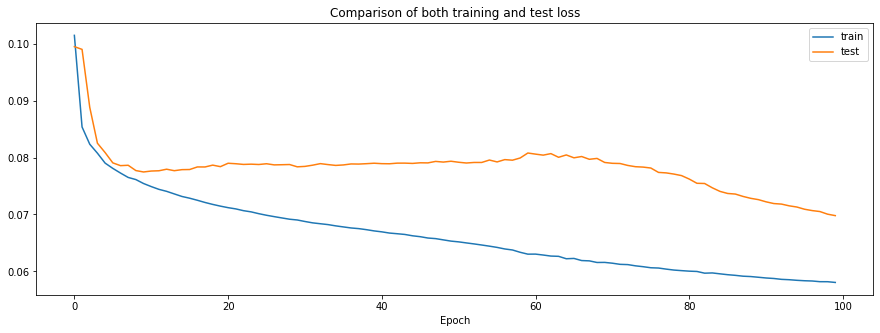

In [27]:
plt.figure(figsize = (15,5))
_ = plt.plot(history.history['loss'], label='train')
_ = plt.plot(history.history['val_loss'], label='test')

# set labels, legends and show plot
_ = plt.xlabel('Epoch')
_ = plt.legend()
_ = plt.title('Comparison of both training and test loss')

## **Evaluate Model**

We combine the forecast with the test dataset and invert the scaling. We also invert scaling on the test dataset with the expected solar energy production numbers.

With forecasts and actual values in their original scale, we can then calculate an error score for the model. In this case, we calculate the Root Mean Squared Error (RMSE) that gives error in the same units as the variable itself.

In [28]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

In [29]:
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

In [30]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [31]:
# calculate RMSE
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 67.274


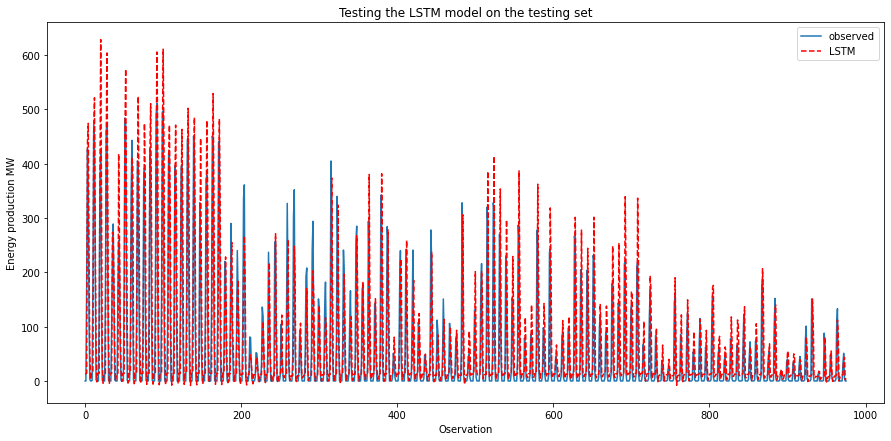

In [32]:
plt.figure(figsize = (15,7))
_ = plt.plot(inv_y, label='observed')

# plot your mean predictions
_ = plt.plot(inv_yhat, 'r--', label='LSTM')

# set labels, legends and show plot
_ = plt.xlabel('Oservation')
_ = plt.ylabel('Energy production MW')
_ = plt.legend()
_ = plt.title('Testing the LSTM model on the testing set')

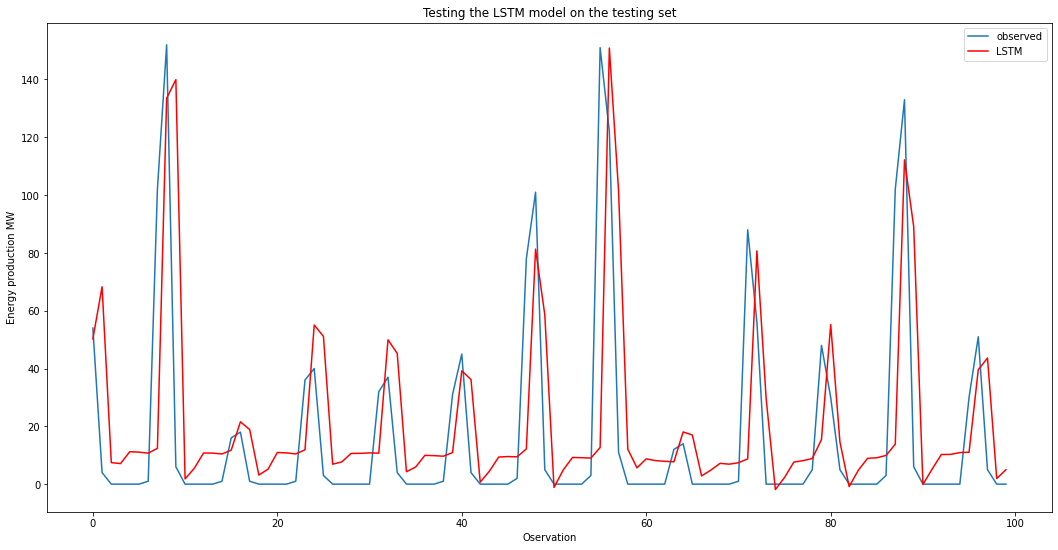

In [33]:
plt.figure(figsize = (18,9))
_ = plt.plot(inv_y[-100:], label='observed')

# plot your mean predictions
_ = plt.plot(inv_yhat[-100:], color='r', label='LSTM')

# set labels, legends and show plot
_ = plt.xlabel('Oservation')
_ = plt.ylabel('Energy production MW')
_ = plt.legend()
_ = plt.title('Testing the LSTM model on the testing set')

In [34]:
def error_metrics(y_pred, y_truth, model_name = None):
    """
    Printing error metrics like RMSE (root mean square error), R2 score, 
    MAE (mean absolute error). 
    
    y_pred: predicted values of y using the model model_name
    y_truth: observed values of y
    model_name: name of the model used for predictions
    
    The function will print the RMSE, R2, MAE error metrics for the model_name
    """
    if isinstance(y_pred, np.ndarray):
        y_pred = y_pred
    else:
        y_pred = y_pred.to_numpy()
        
    if isinstance(y_truth, np.ndarray):
        y_truth = y_truth
    else:
        y_truth = y_truth.to_numpy()
        
    print('\nError metrics for model {}'.format(model_name))
    
    RMSE = np.sqrt(mean_squared_error(y_truth, y_pred))
    print("RMSE or Root mean squared error: %.2f" % RMSE)
    
    # Explained variance score: 1 is perfect prediction

    R2 = r2_score(y_truth, y_pred)
    print('Variance score: %.2f' % R2 )

    MAE = mean_absolute_error(y_truth, y_pred)
    print('Mean Absolute Error: %.2f' % MAE)

In [35]:
error_metrics(inv_yhat, inv_y, model_name = 'LSTM - first trial')


Error metrics for model LSTM - first trial
RMSE or Root mean squared error: 67.27
Variance score: 0.60
Mean Absolute Error: 41.25


# **Reduced Feature Space**

**Trying different columns this time**
* In the above model we had used hot encoded variables like hour_1, hour_2,..., month_2, month_3,.. etc. This results in a loss of information because the model assumes that 23rd hour is far away from the 0th hour (and same for months, month_12 is far away from month_1) which is not the case because the time series is periodic and the 0th hour is as much closer to the 23rd hour as it is to the 1st hour. To avoid the loss of information and to lower the number of predictor variables we'll try some feature engineering on the X space.
* We'll also create a season column to capture the months feature. 

In [36]:
# Dividing the hours into 4 groups-> night, morning, afternoon, evening
hour_dict = {'morning': list(np.arange(7,13)),'afternoon': list(np.arange(13,16)), 'evening': list(np.arange(16,22)),
            'night': [22, 23, 0, 1, 2, 3, 4, 5, 6]}
#Dividing the months into 4 groups-> spring, summer, autumn, winter
month_dict = {'spring': list(np.arange(3,6)),'summer': list(np.arange(6,9)), 'autumn': list(np.arange(9,12)),
            'winter': [12, 1, 2]}

In [37]:
def time_of_day(x):
    if x in hour_dict['morning']:
        return 'morning'
    elif x in hour_dict['afternoon']:
        return 'afternoon'
    elif x in hour_dict['evening']:
        return 'evening'
    else:
        return 'night'

def season(x):
    if x in month_dict['spring']:
        return 'spring'
    elif x in month_dict['summer']:
        return 'summer'
    elif x in month_dict['autumn']:
        return 'autumn'
    else:
        return 'winter'

In [38]:
df['time_of_day']= df['hour'].apply(time_of_day)
df['season'] = df['month'].apply(season)

In [39]:
# creating categorical columns for linear regression 
cat_cols1 = ['month', 'hour', 'season', 'time_of_day']
#not including year above to capture the increasing energy trend over increasing value of years
for col in cat_cols1:
    df[col] = df[col].astype('category')

In [40]:
df = df.drop(columns=['hour', 'month'])
df = pd.get_dummies(df, drop_first=True)
df.head()

,Solaire (MW),air_temp,precip_depth_per_hour,station_pressure_rate,Vitesse du vent à 100m (m/s),Rayonnement solaire global (W/m2),year,time_of_day_evening,time_of_day_morning,time_of_day_night,season_spring,season_summer,season_winter
date,,,,,,,,,,,,,
2017-01-01 01:00:00,0,-37.0,0.0,10180.0,4.53,0.00,2017,0,0,1,0,0,1
2017-01-01 04:00:00,0,-40.0,0.0,10162.0,5.30,0.00,2017,0,0,1,0,0,1
2017-01-01 07:00:00,0,-41.0,0.0,10144.0,4.92,0.00,2017,0,1,0,0,0,1
2017-01-01 10:00:00,15,-30.0,0.0,10137.0,4.71,7.09,2017,0,1,0,0,0,1
2017-01-01 13:00:00,22,-10.0,0.0,10115.0,4.30,84.24,2017,0,0,0,0,0,1


In [41]:
values = df.values

In [42]:
# ensure all data is float
values = values.astype('float32')

In [43]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [44]:
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

In [45]:
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var11(t-1),var12(t-1),var13(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t),var9(t),var10(t),var11(t),var12(t),var13(t)
1,0.000000,0.067762,0.0,0.742188,0.205197,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.000000,0.061602,0.0,0.718750,0.274194,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,0.000000,0.061602,0.0,0.718750,0.274194,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.000000,0.059548,0.0,0.695312,0.240143,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,0.000000,0.059548,0.0,0.695312,0.240143,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.025381,0.082136,0.0,0.686197,0.221326,0.008387,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0.025381,0.082136,0.0,0.686197,0.221326,0.008387,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.037225,0.123203,0.0,0.657552,0.184588,0.099649,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5,0.037225,0.123203,0.0,0.657552,0.184588,0.099649,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.001692,0.131417,0.0,0.656250,0.166667,0.101198,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [46]:
# drop columns we don't want to predict
reframed.drop(reframed.columns[[14,15,16,17,18,19,20,21,22,23,24,25]], axis = 1, inplace = True)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var11(t-1),var12(t-1),var13(t-1),var1(t)
1,0.000000,0.067762,0.0,0.742188,0.205197,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.000000
2,0.000000,0.061602,0.0,0.718750,0.274194,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.000000
3,0.000000,0.059548,0.0,0.695312,0.240143,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.025381
4,0.025381,0.082136,0.0,0.686197,0.221326,0.008387,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.037225
5,0.037225,0.123203,0.0,0.657552,0.184588,0.099649,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.001692


In [47]:
reframed.shape

(11687, 14)

In [48]:
# split into train and test sets
values = reframed.values
split = 10703 # corresponding to the "2020-09-01"
train = values[:split, :]
test = values[split:, :]

In [49]:
print(train.shape, test.shape)

(10703, 14) (984, 14)


In [50]:
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(10703, 1, 13) (10703,) (984, 1, 13) (984,)


In [51]:
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam', metrics = ['accuracy'])

In [52]:
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=96, validation_data=(test_X, test_y), verbose=1, shuffle=False)

Epoch 1/100
112/112 [==============================] - 3s 9ms/step - loss: 0.0872 - accuracy: 0.4187 - val_loss: 0.0841 - val_accuracy: 0.4919
Epoch 2/100
112/112 [==============================] - 1s 6ms/step - loss: 0.0622 - accuracy: 0.4187 - val_loss: 0.0914 - val_accuracy: 0.4919
Epoch 3/100
112/112 [==============================] - 0s 4ms/step - loss: 0.0668 - accuracy: 0.4187 - val_loss: 0.1252 - val_accuracy: 0.4919
Epoch 4/100
112/112 [==============================] - 0s 4ms/step - loss: 0.0634 - accuracy: 0.4187 - val_loss: 0.0778 - val_accuracy: 0.4919
Epoch 5/100
112/112 [==============================] - 0s 4ms/step - loss: 0.0457 - accuracy: 0.4187 - val_loss: 0.0546 - val_accuracy: 0.4919
Epoch 6/100
112/112 [==============================] - 0s 4ms/step - loss: 0.0474 - accuracy: 0.4187 - val_loss: 0.0771 - val_accuracy: 0.4919
Epoch 7/100
112/112 [==============================] - 0s 4ms/step - loss: 0.0537 - accuracy: 0.4187 - val_loss: 0.0551 - val_accuracy: 0.4919

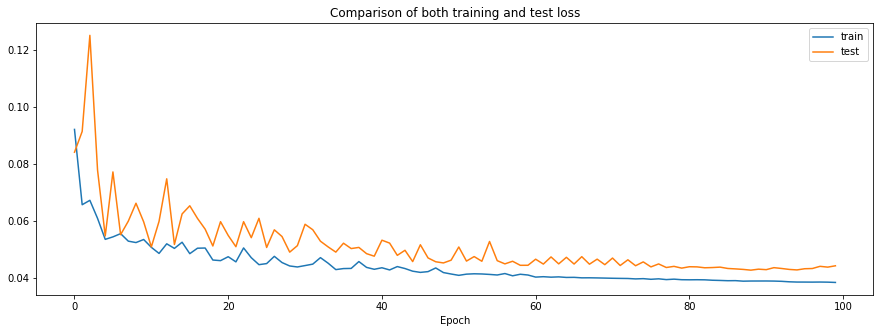

In [53]:
plt.figure(figsize = (15,5))
_ = plt.plot(history.history['loss'], label='train')
_ = plt.plot(history.history['val_loss'], label='test')

# set labels, legends and show plot
_ = plt.xlabel('Epoch')
_ = plt.legend()
_ = plt.title('Comparison of both training and test loss')

In [54]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

In [55]:
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

In [56]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [57]:
# calculate RMSE
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 47.112


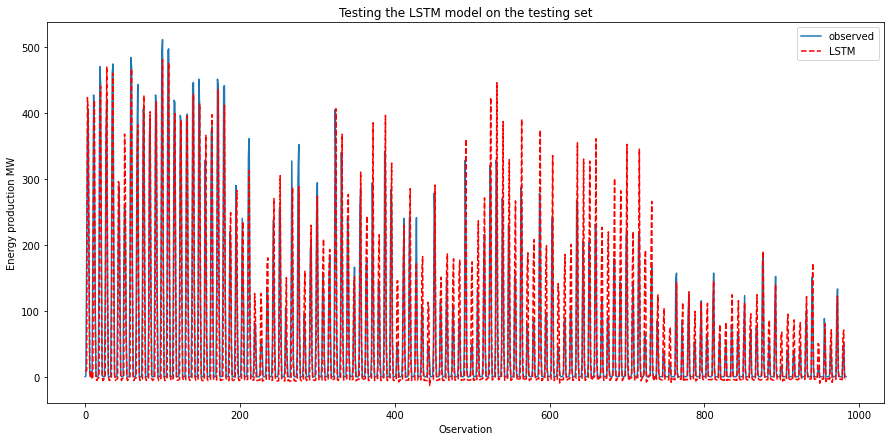

In [58]:
plt.figure(figsize = (15,7))
_ = plt.plot(inv_y, label='observed')

# plot your mean predictions
_ = plt.plot(inv_yhat, 'r--', label='LSTM')

# set labels, legends and show plot
_ = plt.xlabel('Oservation')
_ = plt.ylabel('Energy production MW')
_ = plt.legend()
_ = plt.title('Testing the LSTM model on the testing set')

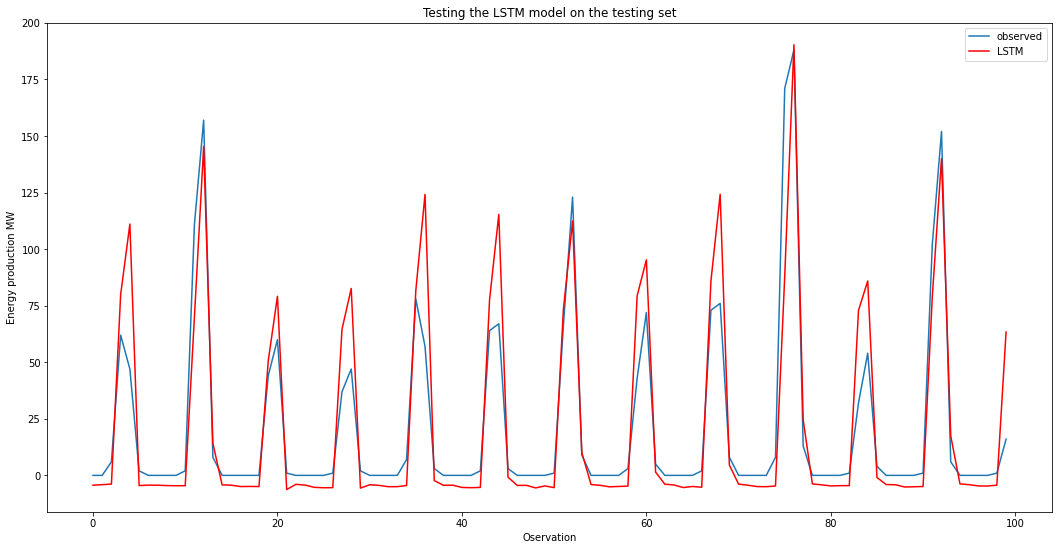

In [59]:
plt.figure(figsize = (18,9))
_ = plt.plot(inv_y[800:900], label='observed')

# plot your mean predictions
_ = plt.plot(inv_yhat[800:900], color='r', label='LSTM')

# set labels, legends and show plot
_ = plt.xlabel('Oservation')
_ = plt.ylabel('Energy production MW')
_ = plt.legend()
_ = plt.title('Testing the LSTM model on the testing set')

In [60]:
error_metrics(inv_yhat, inv_y, model_name = 'LSTM - second trial')


Error metrics for model LSTM - second trial
RMSE or Root mean squared error: 47.11
Variance score: 0.81
Mean Absolute Error: 26.08


## CNN + LSTM Network

In [61]:
from keras.layers import Conv1D, MaxPooling1D, Dropout, Flatten

In [99]:
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(10703, 1, 13) (10703,) (984, 1, 13) (984,)


In [100]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, strides=1, padding = 'causal', activation='relu', input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(MaxPooling1D(pool_size=1, strides=2))
model.add(Conv1D(filters=128, kernel_size=3, strides=1, padding = 'causal', activation='relu'))
model.add(MaxPooling1D(pool_size=1, strides=2))
model.add(Conv1D(filters=256, kernel_size=3, strides=1, padding = 'causal', activation='relu'))
model.add(MaxPooling1D(pool_size=1, strides=2))
model.add(Conv1D(filters=128, kernel_size=3, strides=1, padding = 'causal', activation='relu'))
model.add(MaxPooling1D(pool_size=1, strides=2))
model.add(Conv1D(filters=64, kernel_size=3, strides=1, padding = 'causal', activation='relu'))
model.add(MaxPooling1D(pool_size=1, strides=2))

model.add(LSTM(64, return_sequences=True))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(256, return_sequences=True))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(64, return_sequences=True))

model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(1))

In [101]:
model.compile(loss='mse', optimizer= 'adam', metrics=['accuracy'])

In [102]:
history = model.fit(train_X, train_y, epochs=100, batch_size=96, verbose=0, validation_data=(test_X, test_y))

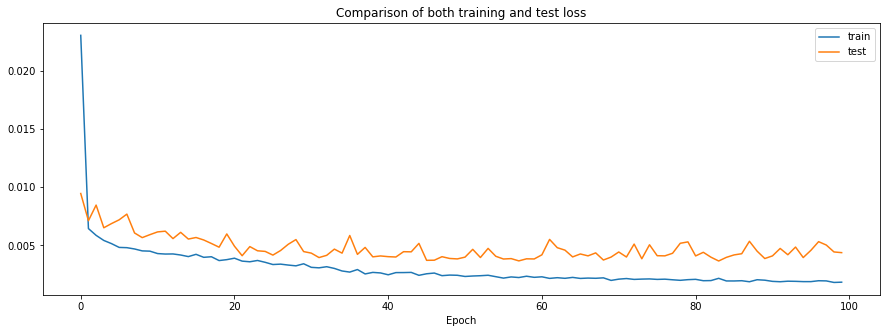

In [103]:
plt.figure(figsize = (15,5))
_ = plt.plot(history.history['loss'], label='train')
_ = plt.plot(history.history['val_loss'], label='test')

# set labels, legends and show plot
_ = plt.xlabel('Epoch')
_ = plt.legend()
_ = plt.title('Comparison of both training and test loss')

In [104]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

In [105]:
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

In [106]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [107]:
# calculate RMSE
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 39.060


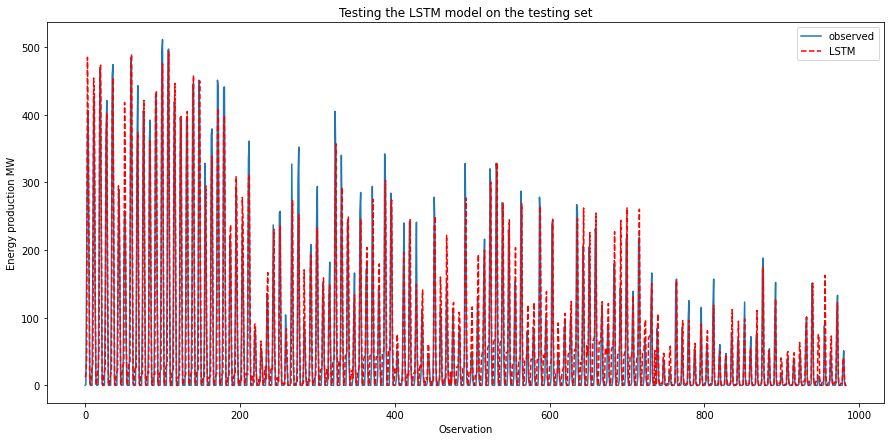

In [108]:
plt.figure(figsize = (15,7))
_ = plt.plot(inv_y, label='observed')

# plot your mean predictions
_ = plt.plot(inv_yhat, 'r--', label='LSTM')

# set labels, legends and show plot
_ = plt.xlabel('Oservation')
_ = plt.ylabel('Energy production MW')
_ = plt.legend()
_ = plt.title('Testing the LSTM model on the testing set')

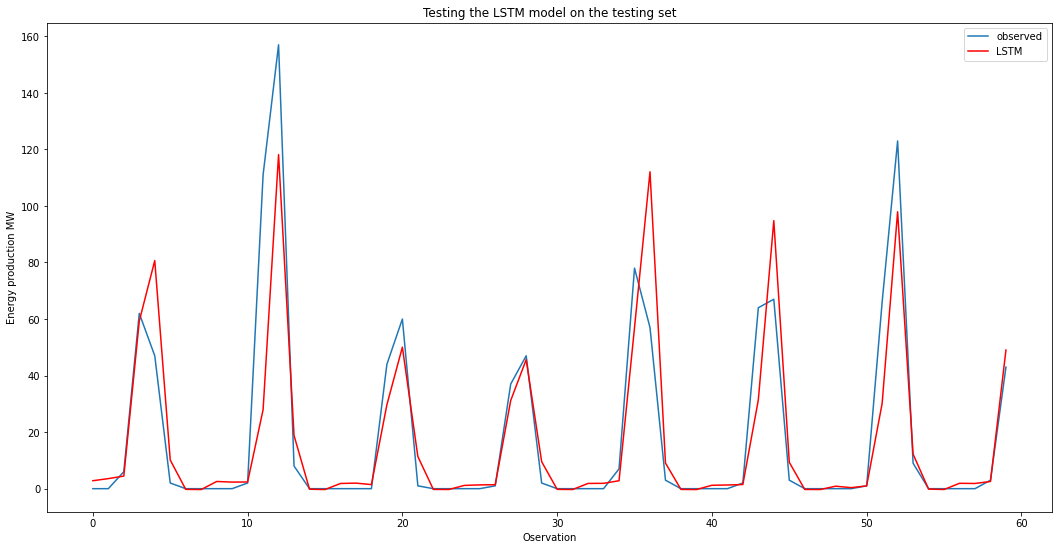

In [116]:
plt.figure(figsize = (18,9))
_ = plt.plot(inv_y[800:860], label='observed')

# plot your mean predictions
_ = plt.plot(inv_yhat[800:860], color='r', label='LSTM')

# set labels, legends and show plot
_ = plt.xlabel('Oservation')
_ = plt.ylabel('Energy production MW')
_ = plt.legend()
_ = plt.title('Testing the LSTM model on the testing set')

In [117]:
error_metrics(inv_yhat, inv_y, model_name = 'Hybrid Network')


Error metrics for model Hybrid Network
RMSE or Root mean squared error: 39.06
Variance score: 0.87
Mean Absolute Error: 23.79
